# Projet 9 - Prédiction demande en électricité en France

Enercoop, société coopérative spécialisée dans les énergies renouvelables.
Elle fait face à certains défis: 
- Energies renouvelables intermittente: difficulté de prévoir les capacités de production d'électricité. 
- Demande en électricité qui varie au cours du temps, et dépend de paramètres comme la météo (température, luminosité, etc.) 

Objectif: mettre en adéquation l'offre et la demande !

## Tableau des matières
- Mission 1: Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.
- Mission 2: Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.
- Mission 3: Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

## URL to get the data
RTE website, Réseau de transport d'électricité : https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_energie_M.zip

Calcul du DJU : Le degré jour est une valeur représentative de l’écart entre la température d’une journée donnée et un seuil de température préétabli (18 °C dans le cas des DJU ou Degré Jour Unifié). Sommés sur une période, ils permettent de calculer les besoins de chauffage et de climatisation d’un bâtiment

https://cegibat.grdf.fr/simulateur/calcul-dju

## Library for the project

In [1]:
import os
import pandas as pd
import sklearn
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns 
pd.set_option('display.max_columns', None)

# MISSION I : DATA CLEANING - LINEAR REGRESSION

## I - Data Cleaning

### A- Consummation data

In [2]:
# Load the data consummation from https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_energie_M.zip
electrecity_consumation = pd.read_csv('./data/consomation.csv', sep = ';')
print(electrecity_consumation.shape)
electrecity_consumation.head()


(1390, 22)


,Mois,QualitÈ,Territoire,Production totale,Production nuclÈaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production Èolien,Production solaire,Production bioÈnergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01,DonnÈes dÈfinitives,France,57177,42811.0,5399,741.0,691,3967,6741,1587,125,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02,DonnÈes dÈfinitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,1123,216,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03,DonnÈes dÈfinitives,France,48583,37549.0,5276,1435.0,666,3175,3894,977,356,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
3,2012-04,DonnÈes dÈfinitives,France,44192,33100.0,3484,1655.0,486,1343,5302,1572,329,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
4,2012-05,DonnÈes dÈfinitives,France,40433,29058.0,1772,854.0,368,549,7706,974,454,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0


In [3]:
electrecity_consumation['QualitÈ'].value_counts()

DonnÈes dÈfinitives    1104
DonnÈes consolidÈes     286
Name: QualitÈ, dtype: int64

In [4]:
electrecity_consumation['Territoire'].value_counts()

France                     118
Centre-Val de Loire        106
Pays-de-la-Loire           106
Bourgogne-Franche-ComtÈ    106
Normandie                  106
Bretagne                   106
Nouvelle-Aquitaine         106
Auvergne-RhÙne-Alpes       106
Hauts-de-France            106
Ile-de-France              106
PACA                       106
Occitanie                  106
Grand-Est                  106
Name: Territoire, dtype: int64

In [5]:
# Select only 'France'
consumation = electrecity_consumation[electrecity_consumation['Territoire']=='France']
consumation = consumation[consumation['QualitÈ']=='DonnÈes dÈfinitives']

consumation.head()

,Mois,QualitÈ,Territoire,Production totale,Production nuclÈaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production Èolien,Production solaire,Production bioÈnergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01,DonnÈes dÈfinitives,France,57177,42811.0,5399,741.0,691,3967,6741,1587,125,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02,DonnÈes dÈfinitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,1123,216,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03,DonnÈes dÈfinitives,France,48583,37549.0,5276,1435.0,666,3175,3894,977,356,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
3,2012-04,DonnÈes dÈfinitives,France,44192,33100.0,3484,1655.0,486,1343,5302,1572,329,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
4,2012-05,DonnÈes dÈfinitives,France,40433,29058.0,1772,854.0,368,549,7706,974,454,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0


In [6]:
consumation = consumation[['Mois','Consommation totale']]  #select column

consumation.columns = ['date','conso_totale']   #rename column
print(consumation.shape)
consumation.head()

(96, 2)


,date,conso_totale
0,2012-01,51086
1,2012-02,54476
2,2012-03,43156
3,2012-04,40176
4,2012-05,35257


In [7]:
print(consumation.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 1097
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          96 non-null     object
 1   conso_totale  96 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None


In [8]:
# Search outliers 
consumation.sort_values(by='date', ascending=False).head()

,date,conso_totale
1097,2019-12,46974
1084,2019-11,43945
1071,2019-10,36367
1058,2019-09,32213
1045,2019-08,31564


In [9]:
# Search outliers 
consumation.sort_values(by='date', ascending=True).head()

,date,conso_totale
0,2012-01,51086
1,2012-02,54476
2,2012-03,43156
3,2012-04,40176
4,2012-05,35257


In [10]:
#Reset index
consumation = consumation.set_index('date')

# Change the type of Series to datetime
consumation.index = pd.to_datetime(consumation.index)

consumation.head()

,conso_totale
date,
2012-01-01,51086
2012-02-01,54476
2012-03-01,43156
2012-04-01,40176
2012-05-01,35257


In [11]:
consumation=consumation.reset_index()
conso_time = consumation.copy()

#Add new column month
conso_time['month']=conso_time['date'].dt.month
conso_time.head()

,date,conso_totale,month
0,2012-01-01,51086,1
1,2012-02-01,54476,2
2,2012-03-01,43156,3
3,2012-04-01,40176,4
4,2012-05-01,35257,5


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Mean Electricity Consumation per month')

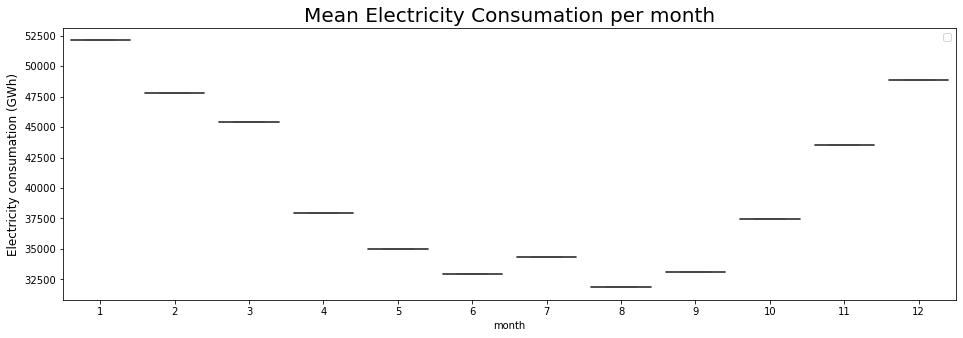

In [12]:
#Vizualisation mean consumation per month

conso_time=conso_time.groupby(by="month").mean()
conso_time=conso_time.reset_index()
plt.figure(figsize=(16, 5))

ax = sns.boxplot(x="month", y="conso_totale",data=conso_time)
plt.ylabel("Electricity consumation (GWh)", fontsize=12), plt.legend()
plt.title("Mean Electricity Consumation per month", fontsize=20)

La consommation d'éléctricité est à la hausse à l'automne et l'hiver. 

In [13]:
#Reset index
consumation =consumation[['date','conso_totale']]
consumation = consumation.set_index('date')

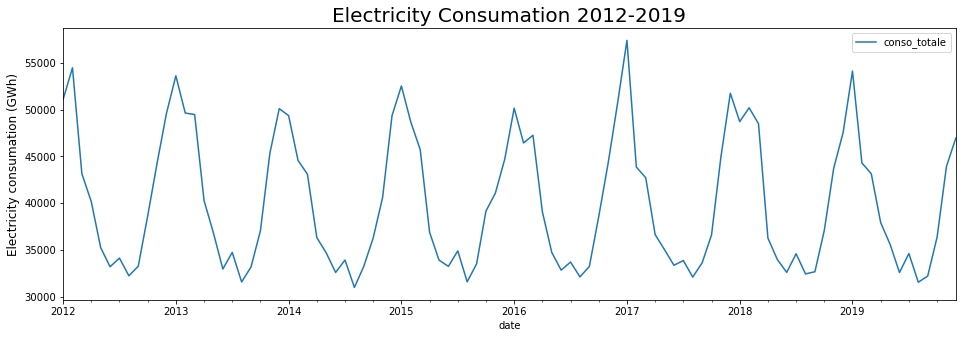

In [14]:
consumation.plot(figsize=(16,5))
plt.ylabel("Electricity consumation (GWh)", fontsize=12), plt.legend()
plt.title("Electricity Consumation 2012-2019", fontsize=20), 
plt.legend()
plt.show()

Dans la série temporelle ci-dessus on peut identifier des cycles assez réguliers au cours du temps et de même amplitude. Une correction des données de consommation mensuelles de l'effet température (dues au chauffage électrique) sera faite à l’aide de la régression linéaire.

Il est donc nécessaire d'extraire les données propres au chauffage électrique sur la même pério

In [15]:
# Annual consummation
consumation.resample('Y').sum()

,conso_totale
date,
2012-12-31,489517
2013-12-31,494842
2014-12-31,465150
2015-12-31,476050
2016-12-31,483219
2017-12-31,482008
2018-12-31,478431
2019-12-31,473401


CALCUL DU DJU: Le degré jour est une valeur représentative de l’écart entre la température d’une journée donnée et un seuil de température préétabli (18 °C dans le cas des DJU ou Degré Jour Unifié). Sommés sur une période, ils permettent de calculer les besoins de chauffage et de climatisation d’un bâtiment.

## B- Climatisation data

In [16]:
# Select region Lyon
climatisation=pd.read_excel('data/climatisation.xlsx',skiprows=11)

print(climatisation.info())
climatisation.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Annee   13 non-null     int64  
 1   JAN     13 non-null     int64  
 2   FÉV     13 non-null     int64  
 3   MAR     13 non-null     int64  
 4   AVR     13 non-null     float64
 5   MAI     13 non-null     float64
 6   JUN     13 non-null     float64
 7   JUI     13 non-null     float64
 8   AOÛ     13 non-null     float64
 9   SEP     13 non-null     float64
 10  OCT     13 non-null     float64
 11  NOV     13 non-null     float64
 12  DÉC     13 non-null     int64  
 13  Total   13 non-null     float64
dtypes: float64(9), int64(5)
memory usage: 1.5 KB
None


,Annee,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
0,2021,0,0,0,0.0,6.3,58.8,0.0,0.0,0.0,0.0,0.0,0,65.1
1,2020,0,0,0,2.1,31.2,75.8,193.8,197.5,98.5,1.3,0.0,0,600.0
2,2019,0,0,0,0.8,5.6,132.2,220.9,146.1,54.8,11.2,0.0,0,571.5
3,2018,0,0,0,8.0,38.6,102.9,201.8,196.6,88.8,11.7,0.3,0,648.5
4,2017,0,0,0,0.0,47.5,155.9,175.4,182.7,13.4,5.4,0.0,0,580.1


In [17]:
print(climatisation['Annee'].min())
print(climatisation['Annee'].max())

2009
2021


In [18]:
#Choisir données à partir de 2014
climatisation=climatisation.loc[climatisation['Annee']> 2014]

climatisation=climatisation.drop(columns=['Total'])

# Renommer des colonnes
climatisation.columns = ['year', '01', '02', '03', '04', '05', '06','07', '08', '09', '10', '11', '12']

#Melt colonnes
climatisation = pd.melt(climatisation, id_vars='year', var_name='month', value_name='clim')
climatisation.head()

,year,month,clim
0,2021,01,0.0
1,2020,01,0.0
2,2019,01,0.0
3,2018,01,0.0
4,2017,01,0.0


In [19]:
# Colonne date + réarrangement de la table
climatisation['date'] = climatisation['year'].astype(str) + '-' + climatisation['month']
print(climatisation.shape)
climatisation.head()

(84, 4)


,year,month,clim,date
0,2021,01,0.0,2021-01
1,2020,01,0.0,2020-01
2,2019,01,0.0,2019-01
3,2018,01,0.0,2018-01
4,2017,01,0.0,2017-01


In [20]:
#Choisir colonnes nécessaires
climatisation = climatisation[['date', 'clim']]

#Reset index pour colonne date
climatisation = climatisation.set_index('date')
#Transferer format pour colonne index
climatisation.index = pd.to_datetime(climatisation.index)
# Tri des valeurs par odre chronologique
climatisation = climatisation.sort_index()
climatisation.head()

,clim
date,
2015-01-01,0.0
2015-02-01,0.0
2015-03-01,0.0
2015-04-01,0.0
2015-05-01,18.5


### C- Chauffage data

In [21]:
chauffage=pd.read_excel('data/chauffage.xlsx',skiprows=11)

print(chauffage.info())
chauffage.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Annee   13 non-null     int64  
 1   JAN     13 non-null     float64
 2   FÉV     13 non-null     float64
 3   MAR     13 non-null     float64
 4   AVR     13 non-null     float64
 5   MAI     13 non-null     float64
 6   JUN     13 non-null     float64
 7   JUI     13 non-null     float64
 8   AOÛ     13 non-null     float64
 9   SEP     13 non-null     float64
 10  OCT     13 non-null     float64
 11  NOV     13 non-null     float64
 12  DÉC     13 non-null     float64
 13  Total   13 non-null     float64
dtypes: float64(13), int64(1)
memory usage: 1.5 KB
None


,Annee,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
0,2021,444.2,260.0,284.3,209.9,114.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1312.7
1,2020,376.9,264.9,258.8,88.3,46.5,12.4,0.0,0.1,35.8,154.3,253.0,361.8,1852.6
2,2019,445.9,308.7,237.6,170.4,106.6,15.3,0.0,1.6,14.7,83.8,284.6,327.4,1996.4
3,2018,301.4,430.4,291.8,97.8,47.2,0.3,0.0,1.5,13.3,122.8,264.9,355.7,1926.9
4,2017,532.2,271.1,205.4,180.8,80.7,3.7,1.3,2.0,49.1,110.0,328.5,409.8,2174.3


In [22]:
print(chauffage['Annee'].min())
print(chauffage['Annee'].max())

2009
2021


In [23]:
#Choisir données à partir de 2014
chauffage=chauffage.loc[chauffage['Annee']>= 2014]

chauffage=chauffage.drop(columns=['Total'])

# Renommer des colonnes
chauffage.columns = ['year', '01', '02', '03', '04', '05', '06','07', '08', '09', '10', '11', '12']

#Melt colonnes
chauffage = pd.melt(chauffage, id_vars='year', var_name='month', value_name='chauffage')
chauffage.head()

,year,month,chauffage
0,2021,01,444.2
1,2020,01,376.9
2,2019,01,445.9
3,2018,01,301.4
4,2017,01,532.2


In [24]:
# Colonne date + réarrangement de la table
chauffage['date'] = chauffage['year'].astype(str) + '-' + chauffage['month']
print(chauffage.shape)
chauffage.head()

(84, 4)


,year,month,chauffage,date
0,2021,01,444.2,2021-01
1,2020,01,376.9,2020-01
2,2019,01,445.9,2019-01
3,2018,01,301.4,2018-01
4,2017,01,532.2,2017-01


In [25]:
#Select column
chauffage = chauffage[['date', 'chauffage']]

#Reset index pour colonne date
chauffage = chauffage.set_index('date')

#Transferer format pour colonne index
chauffage.index = pd.to_datetime(chauffage.index)
# Tri des valeurs par odre chronologique
chauffage = chauffage.sort_index()
chauffage.head()

,chauffage
date,
2015-01-01,419.5
2015-02-01,393.2
2015-03-01,276.1
2015-04-01,143.4
2015-05-01,49.1


### D- Dju

In [481]:
dju=climatisation_df.merge(chauffage_df,on='mois',how='inner')
print(dju.shape)
dju.head()

(156, 3)


,mois,climatisation,chauffage
0,2021-01-01,0.0,444.2
1,2021-02-01,0.0,260.0
2,2021-03-01,0.0,284.3
3,2021-04-01,0.0,209.9
4,2021-05-01,6.3,114.4


In [482]:
print(dju['mois'].min())
print(dju['mois'].max())

2009-01-01 00:00:00
2021-12-01 00:00:00


In [483]:
dju['dju']=dju['chauffage']+dju['climatisation']
dju.head()

,mois,climatisation,chauffage,dju
0,2021-01-01,0.0,444.2,444.2
1,2021-02-01,0.0,260.0,260.0
2,2021-03-01,0.0,284.3,284.3
3,2021-04-01,0.0,209.9,209.9
4,2021-05-01,6.3,114.4,120.7


<AxesSubplot:xlabel='mois'>

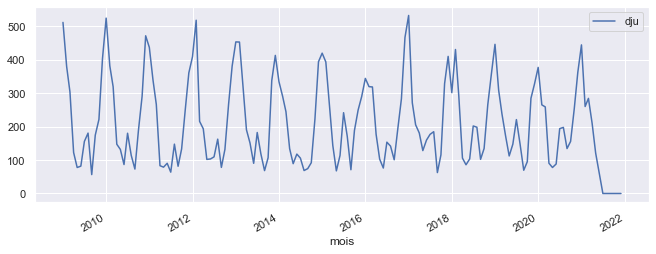

In [484]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

# Série sunspot : nombre annuel de tâches solaires de 1790 à 1970
dju.plot(y="dju",x='mois')

#### Merge

In [485]:
print(dju.shape)

(156, 4)


In [486]:
print(consumation.shape)

(96, 1)


In [487]:
df=consumation.merge(dju,on='mois',how='inner')
df.head()

,mois,consommation_totale,climatisation,chauffage,dju
0,2012-01-01,51086,0.0,409.0,409.0
1,2012-02-01,54476,0.0,517.9,517.9
2,2012-03-01,43156,0.0,215.6,215.6
3,2012-04-01,40176,2.2,191.2,193.4
4,2012-05-01,35257,33.5,68.4,101.9


In [488]:
df.isnull().sum()

mois                   0
consommation_totale    0
climatisation          0
chauffage              0
dju                    0
dtype: int64

In [489]:
df.describe()

,consommation_totale,climatisation,chauffage,dju
count,96.000000,96.000000,96.000000,96.000000
mean,40027.270833,42.035417,175.957292,217.992708
std,7086.782850,64.691688,157.468679,121.842924
min,31004.000000,0.000000,0.000000,62.500000
25%,33696.750000,0.000000,14.650000,111.525000
50%,37082.500000,0.850000,147.150000,186.650000
75%,45417.250000,65.625000,303.225000,303.225000
max,57406.000000,241.500000,532.200000,532.200000


In [490]:
df.dju.value_counts

<bound method IndexOpsMixin.value_counts of 0     409.0
1     517.9
2     215.6
3     193.4
4     101.9
      ...  
91    147.7
92     69.5
93     95.0
94    284.6
95    327.4
Name: dju, Length: 96, dtype: float64>

In [491]:
df.tail()

,mois,consommation_totale,climatisation,chauffage,dju
91,2019-08-01,31564,146.1,1.6,147.7
92,2019-09-01,32213,54.8,14.7,69.5
93,2019-10-01,36367,11.2,83.8,95.0
94,2019-11-01,43945,0.0,284.6,284.6
95,2019-12-01,46974,0.0,327.4,327.4


In [492]:
df.dtypes

mois                   datetime64[ns]
consommation_totale             int64
climatisation                 float64
chauffage                     float64
dju                           float64
dtype: object

In [493]:
df = df[df['mois'] <= pd.to_datetime('2021-06-01')]

df.tail()

,mois,consommation_totale,climatisation,chauffage,dju
91,2019-08-01,31564,146.1,1.6,147.7
92,2019-09-01,32213,54.8,14.7,69.5
93,2019-10-01,36367,11.2,83.8,95.0
94,2019-11-01,43945,0.0,284.6,284.6
95,2019-12-01,46974,0.0,327.4,327.4


In [494]:
df.describe()

,consommation_totale,climatisation,chauffage,dju
count,96.000000,96.000000,96.000000,96.000000
mean,40027.270833,42.035417,175.957292,217.992708
std,7086.782850,64.691688,157.468679,121.842924
min,31004.000000,0.000000,0.000000,62.500000
25%,33696.750000,0.000000,14.650000,111.525000
50%,37082.500000,0.850000,147.150000,186.650000
75%,45417.250000,65.625000,303.225000,303.225000
max,57406.000000,241.500000,532.200000,532.200000


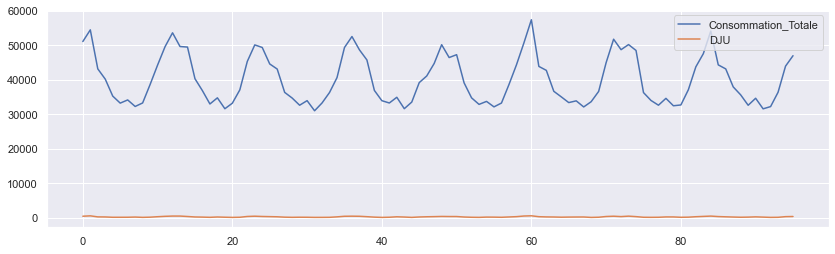

In [495]:
df['consommation_totale'].plot(figsize=(14,4),label="Consommation_Totale")
df['dju'].plot(figsize=(14,4),label="DJU")
plt.legend()

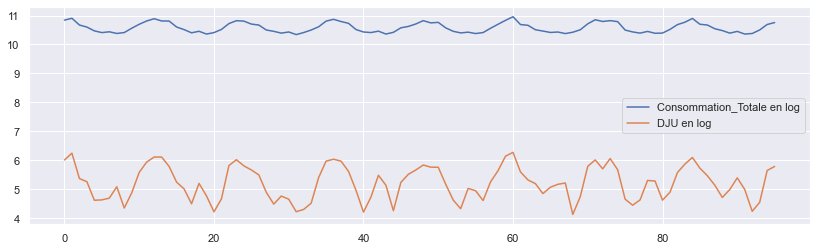

In [496]:
np.log(df['consommation_totale']).plot(figsize=(14,4),label="Consommation_Totale en log")
np.log(df['dju']).plot(figsize=(14,4),label="DJU en log")
plt.legend()

## PARTIE II - Désaisonnalisez à l'aide de la régression linéaire

Rq: modele additif ou multiplicatif ? regarder les écarts sur une série temporelle mensuelle qui a une saisonnalité annuelle (tous les deux points). Il suffit de regarder les écarts entre les piques et les creux sur une période, si cet écart s accroit ou decroit on est sur un modele multiplicatif

Rq: time serie a 3 choses -une tendance (traduit le niveau moyen de la serie temp) -une saisonnalité (c'est l ensemble des fluctualitées qu on va retrouver ds la ST, qlq chose de périodque) -un résidu (la part qu'on ne peut pas expliquer)



In [497]:
df.head()

,mois,consommation_totale,climatisation,chauffage,dju
0,2012-01-01,51086,0.0,409.0,409.0
1,2012-02-01,54476,0.0,517.9,517.9
2,2012-03-01,43156,0.0,215.6,215.6
3,2012-04-01,40176,2.2,191.2,193.4
4,2012-05-01,35257,33.5,68.4,101.9


### Statsmodel

In [498]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [499]:
y = df['consommation_totale']
x = sm.add_constant(df['dju'])

In [500]:
reg = sm.OLS(y, x).fit()
print(reg.summary())

                             OLS Regression Results                            
Dep. Variable:     consommation_totale   R-squared:                       0.878
Model:                             OLS   Adj. R-squared:                  0.877
Method:                  Least Squares   F-statistic:                     676.5
Date:                 Sun, 09 Jan 2022   Prob (F-statistic):           9.99e-45
Time:                         18:18:15   Log-Likelihood:                -885.87
No. Observations:                   96   AIC:                             1776.
Df Residuals:                       94   BIC:                             1781.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.815e+04    522.621     53.85

In [501]:
serie_corr_df = pd.DataFrame({'mois':serie_corrigee.index, 'corrigee':serie_corrigee.values})

Le coefficient de détermination de 87% est très satisfaisant

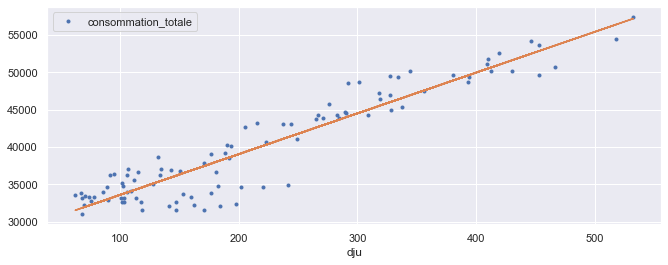

In [502]:
df.plot(x='dju', y='consommation_totale', style='.')
plt.plot(df['dju'], reg.predict(sm.add_constant(df['dju'])))

plt.savefig("p9_graphs/regression_lineaire_conso_dju.png")
plt.show()

In [503]:
#Calcul de la correction : l'effet DJU est retranché à la consommation totale
df['conso_corr'] = df['consommation_totale'] - df['dju']*reg.params['dju']

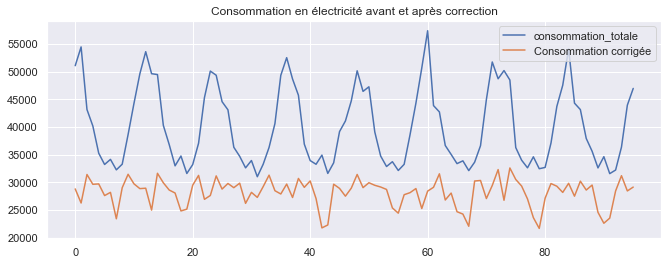

In [504]:
#Visualisation de la consommation en électricité avant et après correction
plt.plot(df['consommation_totale'], label='consommation_totale')
plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.title('Consommation en électricité avant et après correction')

plt.savefig("p9_graphs/conso_corr.png")
plt.legend()
plt.show()

#### Test de normalité des résidus

Text(0.5, 1.0, 'Histogramme des résidus')

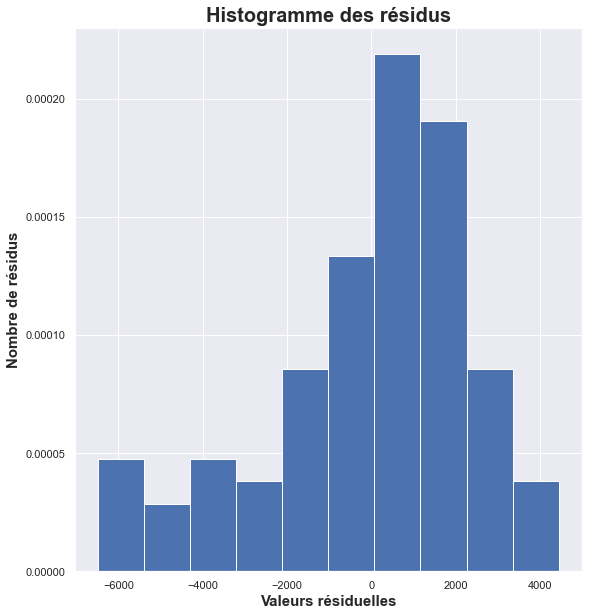

In [505]:
#Visualisation de la normalité des résidus : 
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.hist(reg.resid, density=True)
plt.xlabel('Valeurs résiduelles', fontsize=15, fontweight='bold')
plt.ylabel('Nombre de résidus', fontsize=15, fontweight='bold')
plt.title('Histogramme des résidus', fontsize=20, fontweight='bold')


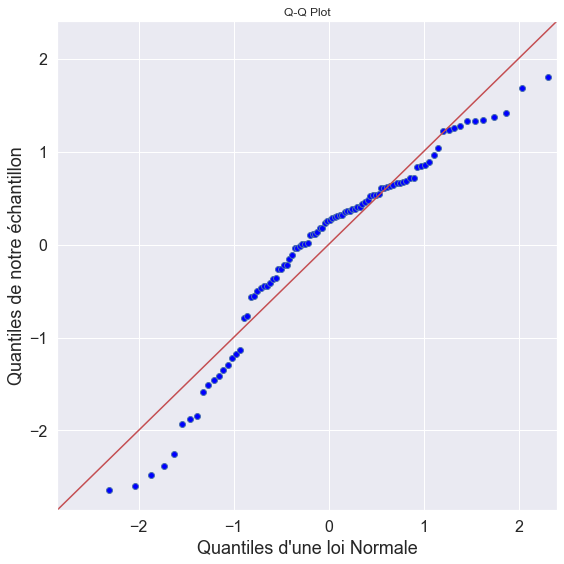

In [506]:
# Droite de Henry:  permet de vérifier si une distribution suit une loi normale
fig, ax = plt.subplots(figsize=(8, 8))

sm.qqplot(reg.resid, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale', fontsize=18)
plt.xticks(fontsize=16)
plt.title('Q-Q Plot')

plt.tight_layout()

plt.show()

## MISSION II: DESAISONNALISATION OF THE CUNSOMMATION 


La méthode seasonal_decompose de statsmodels permet de visualiser la tendance, la saisonnalité et le résidu du signal

In [507]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

<ipython-input-508-793c8cb4ca92>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(df['conso_corr'], model='additive',freq=30)


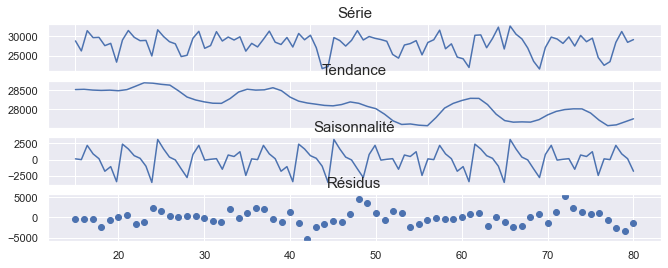

In [508]:
decomposition = seasonal_decompose(df['conso_corr'], model='additive',freq=30)

fig, ax = plt.subplots(4,1)
ax[0].plot(decomposition.observed)
ax[0].set_title('Série', fontsize=15)
ax[1].plot(decomposition.trend)
ax[1].set_title('Tendance', fontsize=15)
ax[2].plot(decomposition.seasonal)
ax[2].set_title('Saisonnalité', fontsize=15)
ax[3].plot(decomposition.resid,'bo')
ax[3].set_title('Résidus', fontsize=15)


plt.show()

In [509]:
#Différence avec la saisonnalité pour obtenir une série temporelle hors impact saisonnier.
df['conso_cvs'] = df['conso_corr'] - decomposition.seasonal

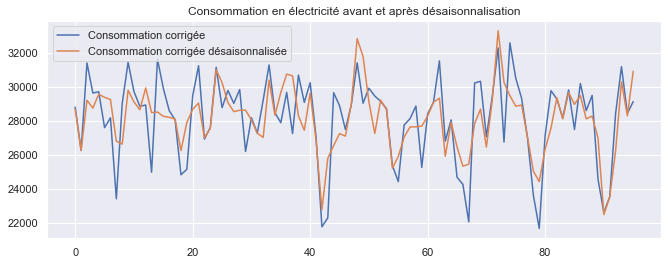

In [510]:
#Visualisation de la consommation en électricité avant et après désaisonnalisation
plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.plot(df['conso_cvs'], label='Consommation corrigée désaisonnalisée')
plt.title('Consommation en électricité avant et après désaisonnalisation')

plt.savefig("p9_graphs/conso_cvs.png")
plt.legend()
plt.show()

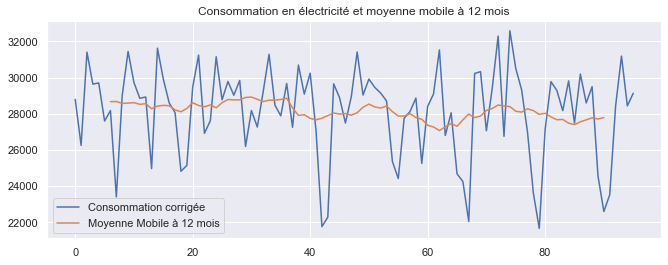

In [511]:
#Visualisation de la consommation en électricité avec moyenne mobile à 12 mois
plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.plot(df['conso_corr'].rolling(12, center=True).mean(), label='Moyenne Mobile à 12 mois')


plt.title('Consommation en électricité et moyenne mobile à 12 mois')

plt.savefig("p9_graphs/conso_moyenne_mobile.png")
plt.legend()
plt.show()

Le moyenne mobile à 12 mois affichée ci-dessus est représentative d'un signal sans tendance, constant sur le timeframe.

## MISSION III - PREVISION OF THE CUNSOMMATION 
- Holt Winters methode 
- SARIMA méthode 

### A- méthode de Holt-Winters 

- révision à l'aide du lissage exponentiel par la méthode de Holt-Winters
- La méthode ExponentialSmoothing de statsmodels est utilisée pour modéliser le lissage exponentiel d'Holt-Winters.

In [512]:
from statsmodels.tsa.api import ExponentialSmoothing

y = np.asarray(df["conso_corr"])
hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [513]:
df = df.set_index('mois')

In [514]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2012-01-01 to 2019-12-01
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   consommation_totale  96 non-null     int64  
 1   climatisation        96 non-null     float64
 2   chauffage            96 non-null     float64
 3   dju                  96 non-null     float64
 4   conso_corr           96 non-null     float64
 5   conso_cvs            96 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 5.2 KB


In [515]:
hw_pred

array([29841.71772542, 27173.92247169, 30630.76239539, 28616.10460296,
       28859.52962233, 25812.42377204, 23851.22826201, 22857.61482878,
       28271.195437  , 30000.25150088, 28129.20422184, 27683.96601107])

In [516]:
df.head()

,consommation_totale,climatisation,chauffage,dju,conso_corr,conso_cvs
mois,,,,,,
2012-01-01,51086,0.0,409.0,409.0,28795.416369,28673.072512
2012-02-01,54476,0.0,517.9,517.9,26250.344101,26247.029178
2012-03-01,43156,0.0,215.6,215.6,31405.755915,29206.547030
2012-04-01,40176,2.2,191.2,193.4,29635.660454,28748.432058
2012-05-01,35257,33.5,68.4,101.9,29703.429164,29556.530261


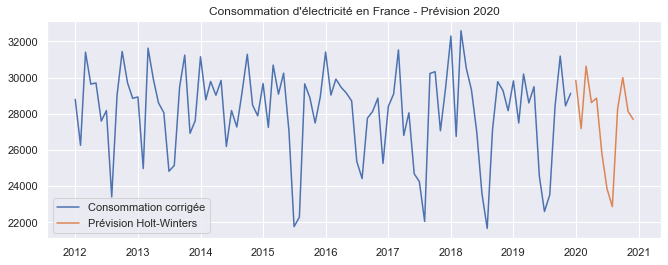

In [517]:
#Visualisation de la prévision à 12 mois par Holt-Winters
plt.plot(df["conso_corr"], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France - Prévision 2020")

plt.savefig("p9_graphs/prevision2019_holt-winters.png")
plt.legend()
plt.show()

La méthode de Holt-Winters est la plus raisonnable des méthodes de lissage exponentiel. La prévision sur un an de la consommation, corrigée de l'effet température, tient compte de la saisonnalité. Ci-dessous une visualisation par restriction sur la période 2018/2019.

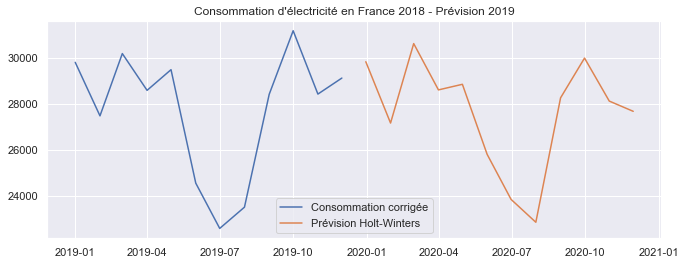

In [518]:
#Visualisation par restriction sur l'année de prévision et n-1 (2018/2019)
plt.plot(df["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France 2018 - Prévision 2019")
        
plt.legend()
plt.savefig("p9_graphs/prevision_visu20182019_holt-winters.png")
plt.show()

#### Analyse a posteriori

On tronque la série de l’année 2018, qu’on cherche ensuite à prévoir à partir de l’historique 2012-2017. Cette analyse permet d'avoir une idée de la qualité prédictive du modèle choisi.

In [519]:
df['2019':].shape

(12, 6)

In [520]:
#Troncature des données sur les années 2017 et 2018
df_tronc = df[:'2018']
x_prevision = df['2019':]

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


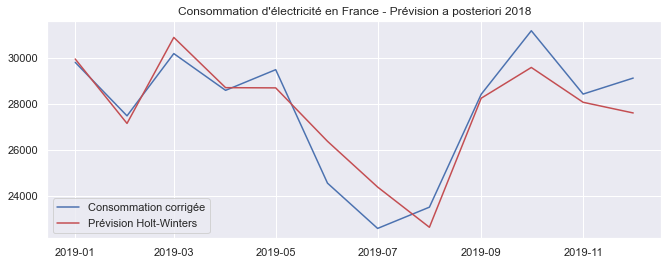

In [521]:
#Visualisation par restriction sur l'année 2018
y = df_tronc["conso_corr"]

hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

plt.plot(df["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(x_prevision.index, hw_pred, color='r', label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France - Prévision a posteriori 2018")

plt.savefig("p9_graphs/prevision_visu20182019_holt-winters_aposteriori.png")
plt.legend()
plt.show()

Par les chiffres nous pouvons calculer le MAPE (Mean Absolute Percentage). L’erreur absolue moyenne en pourcentage, en d'autres termes la moyenne des écarts en valeur absolue par rapport aux valeurs observées.

In [522]:
#Calcul du MAPE
mape = round((np.abs(1-hw_pred/x_prevision["conso_corr"])).mean()*100, 2)
mape

3.2

Une analyse a posteriori sur 24 mois peut également être appliquée pour déterminer d'éventuelles limites prédictives.

In [523]:
#Troncature des données pour une prévision a posteriori de 24 mois
df_tronc = df[:'2017']
x_prevision = df['2018':]

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


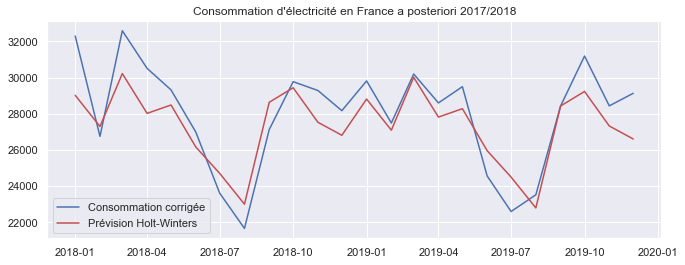

In [524]:
#Visualisation par restriction sur les années de prévision 2018 et 2019
y = df_tronc["conso_corr"]

hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(24)

plt.plot(df["conso_corr"].iloc[-24:], label='Consommation corrigée')
plt.plot(x_prevision.index, hw_pred, color='r', label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France a posteriori 2017/2018")

plt.savefig("p9_graphs/prevision_visu20172018_holt-winters_aposteriori.png")
plt.legend()
plt.show()

In [525]:
#Calcul du MAPE
mape = round((np.abs(1-hw_pred/x_prevision["conso_corr"])).mean()*100, 2)
print("MAPE :" + str(mape))

MAPE :4.6


Cet indicateur nous permettra d'établir une comparaison avec les futures prévisions, et nous pourrons arrêter notre choix sur le modèle le plus performant. Dans l'immédiat, l'analyse a posteriori doublée sur 24 mois permet de penser que le modèle résiste plutôt bien aux impacts saisonniers sur du long terme. Ceci étant, les excédents des pics et creux ne sont pas totalement prévisibles par le modèle, les prévisions SARIMA seront-elles plus représentatives des variations de charge électrique?

### B- Sarima
- Stationnarisation de la série

Prévision à l'aide d'un modèle ARIMA saisonnier de format : SARIMA(p,d,q)(P,D,Q)(t)
Plusieurs étapes sont nécessaires :

Identifier/confirmer la saisonnalité s (autocorrélogrammes)
Stationnariser la série temporelle (différenciation)
Déterminer des ordres optimaux plausibles
Estimer les paramètres et les départager par l’AIC (ou le BIC)
Valider ou non le modèle par un diagnostique des résidus (test, représentation graphique, autocorrélogramme)
Confirmer le(s) choix en simulant la prévision.

In [543]:
import statsmodels.api 
import statsmodels.api as sm
import statsmodels as smt

In [558]:
import statsmodels.api as sm

#Fonction affichant le Test de Dickey–Fuller avec les autocorrélogrammes ACF et PACF
def tsplot(y, lags=None, figsize=(20, 10), style='bmh'):
    """
        Test de Dickey–Fuller 
        avec Autocorrélogrammes ACF et PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

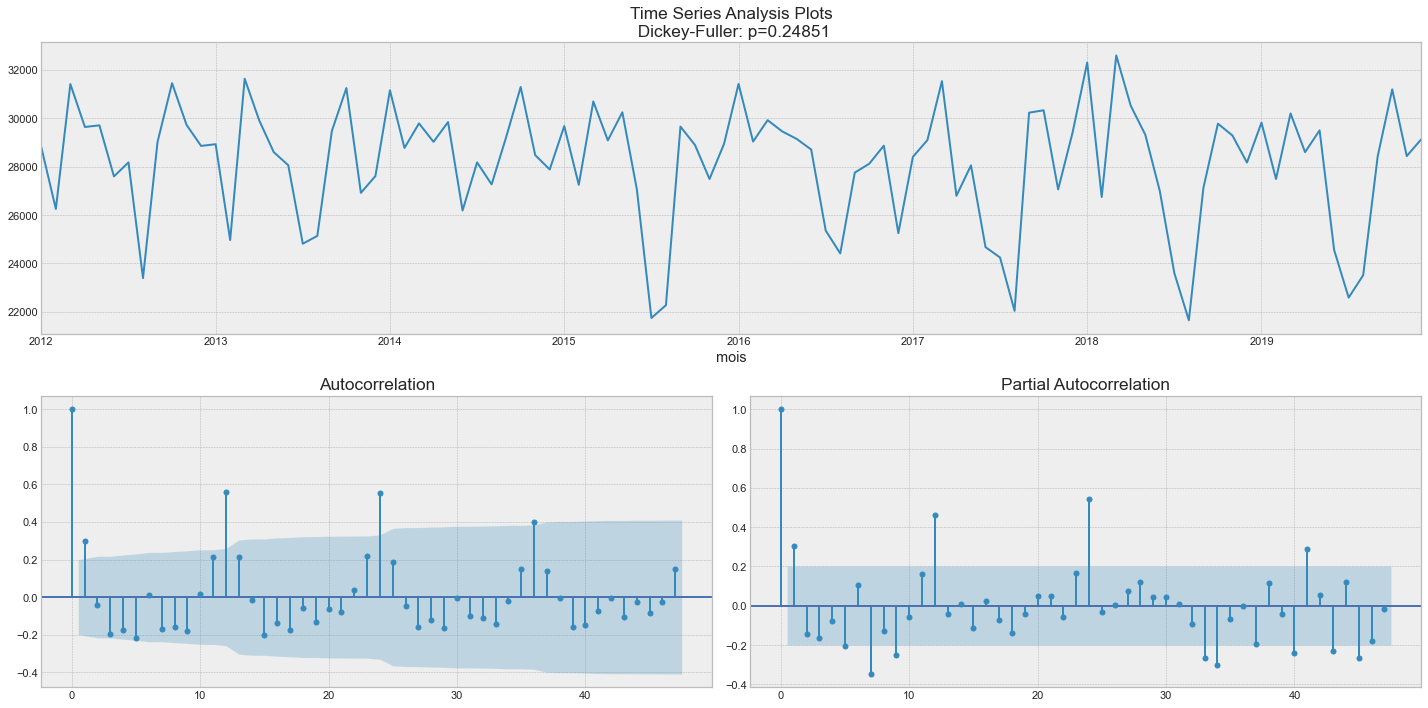

In [560]:
#Test de Dickey–Fuller avec Autocorrélogrammes ACF et PACF
tsplot(df['conso_corr'], lags=47)

La sortie ACF présente une décroissance lente vers 0, ce qui traduit un problème de non-stationnarité. Confirmation également par le test de Dickey-Fuller portant pour hypothèse nulle la non-stationnarité de la série, ne pouvant pas être rejetée. On effectue donc une première différenciation.

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


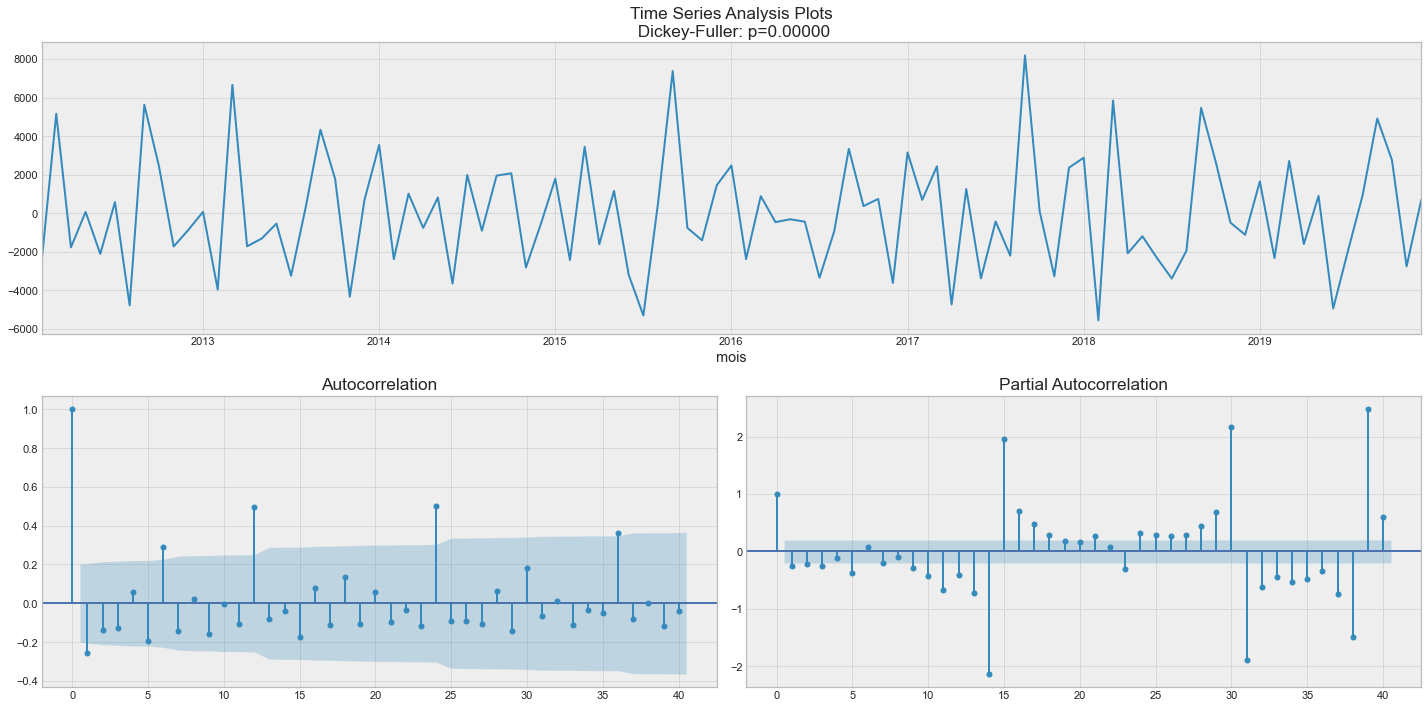

In [562]:
#Première différenciation d'ordre 1 par la méthode .shift()
df_diff1 = df['conso_corr'] - df['conso_corr'].shift(1)
tsplot(df_diff1[1:], lags=40)

La sortie ACF de la série ainsi différenciée présente encore une décroissance lente vers 0 pour les multiples de 12. On effectue cette fois la différenciation d'ordre 12.

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


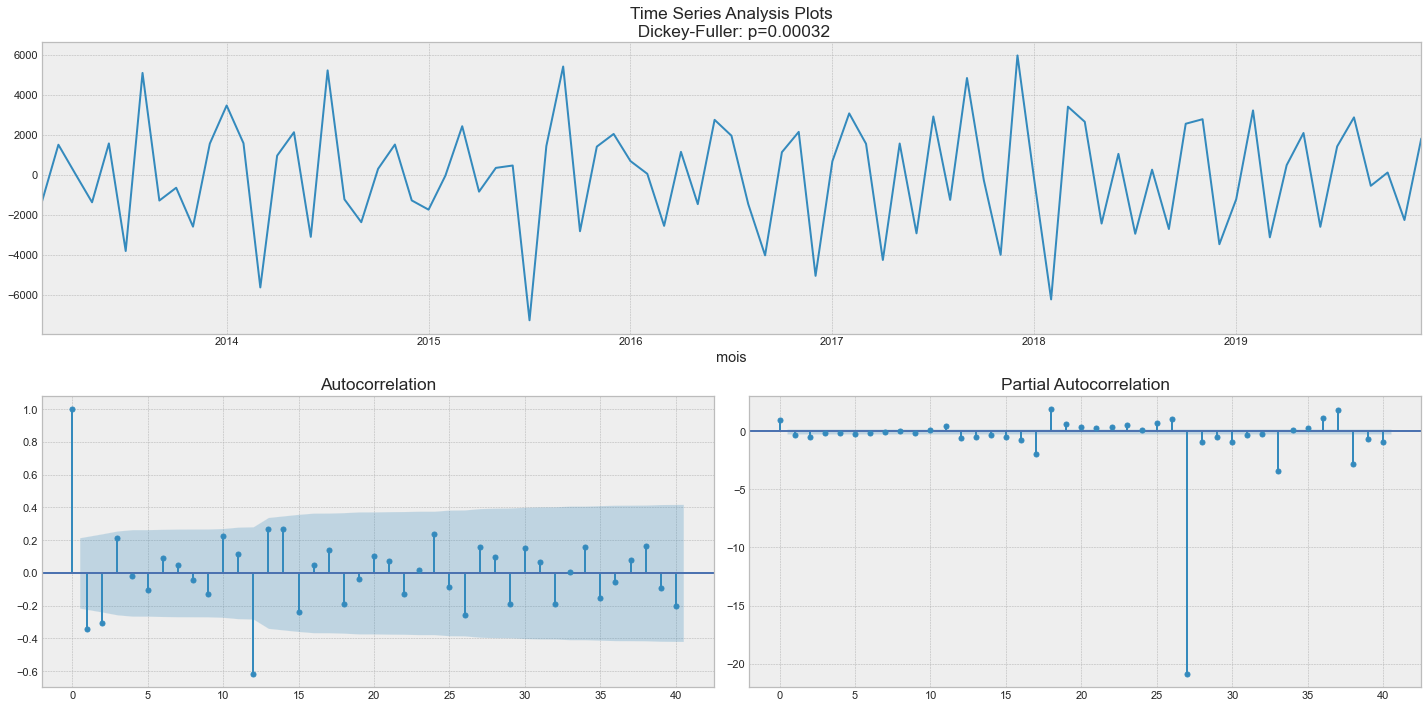

In [563]:
#Seconde différenciation d'ordre 12 
df_diff1_12 = df_diff1 - df_diff1.shift(12)
tsplot(df_diff1_12[13:], lags=40)

Cette fois-ci les résultats sont satisfaisants, nous pouvons nous appuyer sur les autocorrélogrammes simple et partiels estimés.

### Génération d'une configuration optimale SARIMA :

L’identification des combinaisons sera faite par l’approche d’optimisation des polynômes AR et MA. Nous cherchons à minimiser le critère d’information d’Akaike AIC pour déterminer les ordres optimaux. La blancheur et normalité du résidu est également un critère à prendre en compte.

In [ ]:
import statsmodels.api as sm

In [645]:
#Détermination du meilleur modèle de prévision 
from time import time
DUREE_PREDITE = 12 #prédiction sur 12 mois
troncature = DUREE_PREDITE
y = df['conso_corr']
y_prevision = y[-troncature:]

#Calcul de toutes les combinaisons de p, d et q
import itertools
pdq_list = list(itertools.product(range(2),
                             range(2), 
                             range(2)
           ))

#Calcul de toutes les combinaisons de P, D et Q
PDQ_list = [ (*val, 12) for val in list(itertools.product(
                            range(2),
                             range(2), 
                             range(2))
            )]


#Nombre de configurations total pour un modèle SARIMA
n = len(pdq_list) * len(PDQ_list)
print(n)
#Dataframe pour stockage des valeurs
results_SARIMA = pd.DataFrame({'modele':[], 'aic':[], 'bic':[],  'ljungbox':[], 'pvalues':[]})
counter = 1
s_time = time()

#Itération sur toutes les combinaisons
for pdq in pdq_list:
    for PDQ in PDQ_list:
        try:
            #Instanciation et entrainement du modèle SARIMA
            mod = sm.tsa.statespace.SARIMAX(np.asarray(y), order = pdq, seasonal_order = PDQ, 
                          enforce_stationarity=False, enforce_invertibility=False)
            result = mod.fit()
                    
            #Intégration des indicateurs dans le précédent dataframe
            results_SARIMA = results_SARIMA.append({'modele':f"{pdq}x{PDQ}", 
                            'aic': result.aic, 
                            'bic': result.bic,
                            #'ljungbox': sm.stats.acorr_ljungbox(result.resid, lags=12)[1].mean(),
                            'pvalues': result.pvalues.min()}, 
                            ignore_index=True)
        except:
            continue
            
        print(f"{counter}/{n} - {time() - s_time:.0f}s")
        counter += 1


64
1/64 - 0s
2/64 - 0s
3/64 - 0s
4/64 - 0s
5/64 - 0s
6/64 - 0s
7/64 - 0s
8/64 - 0s
9/64 - 0s
10/64 - 0s
11/64 - 0s
12/64 - 0s
13/64 - 0s


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


14/64 - 1s
15/64 - 1s
16/64 - 1s
17/64 - 1s
18/64 - 1s
19/64 - 1s
20/64 - 1s
21/64 - 1s
22/64 - 1s
23/64 - 1s
24/64 - 2s
25/64 - 2s
26/64 - 2s
27/64 - 2s
28/64 - 2s
29/64 - 2s
30/64 - 2s
31/64 - 2s
32/64 - 2s
33/64 - 2s
34/64 - 2s
35/64 - 2s
36/64 - 3s
37/64 - 3s
38/64 - 3s
39/64 - 3s
40/64 - 3s
41/64 - 3s
42/64 - 3s
43/64 - 3s
44/64 - 3s
45/64 - 4s


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


46/64 - 4s
47/64 - 4s
48/64 - 4s
49/64 - 4s
50/64 - 4s
51/64 - 4s
52/64 - 4s
53/64 - 5s
54/64 - 5s
55/64 - 5s
56/64 - 5s
57/64 - 5s
58/64 - 5s
59/64 - 5s
60/64 - 5s
61/64 - 5s
62/64 - 6s
63/64 - 6s
64/64 - 6s


In [649]:
#Sélection des modèles SARIMA les plus optimaux selon les tests de significativité des paramètres 
#et de blancheur du résidu sont validés au niveau 5%
#results_SARIMA_filter = results_SARIMA[(results_SARIMA['ljungbox'] > 0.05)]
results_SARIMA_filter = results_SARIMA[results_SARIMA['pvalues'] < 0.05]

In [650]:
results_SARIMA_filter.head()

,modele,aic,bic,ljungbox,pvalues
1,"(0, 0, 0)x(0, 0, 1, 12)",1884.181830,1889.019511,NaN,0.000000e+00
2,"(0, 0, 0)x(0, 1, 0, 12)",1508.061340,1510.480180,NaN,3.762208e-11
3,"(0, 0, 0)x(0, 1, 1, 12)",1280.721474,1285.246834,NaN,7.047371e-10
4,"(0, 0, 0)x(1, 0, 0, 12)",1526.445792,1531.307426,NaN,0.000000e+00
5,"(0, 0, 0)x(1, 0, 1, 12)",1506.979649,1514.236171,NaN,0.000000e+00


In [651]:
#Utilisation de la fonction .rank() pour déterminer la position de chaque modèle selon la minimisation AIC / BIC
results_SARIMA_filter['rank_aic'] = results_SARIMA_filter['aic'].rank(ascending=True)
results_SARIMA_filter['rank_bic'] = results_SARIMA_filter['bic'].rank(ascending=True)

<ipython-input-651-d02f333e1707>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_SARIMA_filter['rank_aic'] = results_SARIMA_filter['aic'].rank(ascending=True)
<ipython-input-651-d02f333e1707>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_SARIMA_filter['rank_bic'] = results_SARIMA_filter['bic'].rank(ascending=True)


In [652]:
#Visualisation des 30 modèles les plus performants sur les 324 initiaux
def highlight_greaterthan(x):
    if x.rank_aic == 25:
        return ['background-color: #2399f9']*7
    else:
        return ['background-color: None']*7

results_SARIMA_filter.sort_values('rank_aic', ascending=True)[:30].style.apply(highlight_greaterthan, axis=1)



,modele,aic,bic,ljungbox,pvalues,rank_aic,rank_bic
59,"(1, 1, 1)x(0, 1, 1, 12)",1223.812791,1232.749217,nan,0.000000,1.000000,1.000000
31,"(0, 1, 1)x(1, 1, 1, 12)",1224.608657,1233.545083,nan,0.000000,2.000000,2.000000
63,"(1, 1, 1)x(1, 1, 1, 12)",1226.166921,1237.337453,nan,0.000000,3.000000,4.000000
27,"(0, 1, 1)x(0, 1, 1, 12)",1228.217037,1234.919357,nan,0.000000,4.000000,3.000000
15,"(0, 0, 1)x(1, 1, 1, 12)",1230.849268,1239.843249,nan,0.000000,5.000000,5.000000
47,"(1, 0, 1)x(1, 1, 1, 12)",1232.183098,1243.425575,nan,0.000000,6.000000,6.000000
38,"(1, 0, 0)x(1, 1, 0, 12)",1248.988229,1255.776269,nan,0.000000,7.000000,7.000000
39,"(1, 0, 0)x(1, 1, 1, 12)",1250.946644,1259.997364,nan,0.000000,8.000000,9.000000
7,"(0, 0, 0)x(1, 1, 1, 12)",1250.966178,1257.754218,nan,0.000000,9.000000,8.000000
55,"(1, 1, 0)x(1, 1, 1, 12)",1254.414781,1263.408762,nan,0.000001,10.000000,10.000000


Selon la minimisation du critère AIC et BIC , le modèle (1, 1, 1)x(2, 1, 1, 12) ressort comme étant le plus optimal. Ce choix a été fait après plusieurs tests sur plusieurs modèles, il ressort comme étant le plus performant en tenant compte également de la significativité des paramètres, ainsi que la blancheur du résidu estimée à l'aide du test de Ljung–Box. Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%.

In [654]:
#Instanciation et entrainement du modèle SARIMA via statsmodels
model = sm.tsa.statespace.SARIMAX(np.asarray(y), order=(1,1,1), seasonal_order=(2,1,1,12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -750.911
Date:                            Sun, 09 Jan 2022   AIC                           1513.822
Time:                                    20:02:56   BIC                           1528.335
Sample:                                         0   HQIC                          1519.653
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2549      0.378      0.674      0.500      -0.486       0.996
ma.L1         -0.4605      0.369   

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Normalité des résidus :

Dans le cadre de prévisions, il convient de vérifier la normalité des résidus pour tester l'adéquation de nos modèles. La normalité peut-être détectée de façon graphique, mais des tests statistiques amènent un point de vue objectif non négligeable.

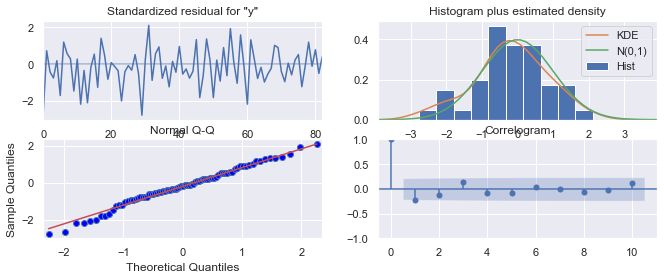

In [655]:
#La fonction .plot_diagnostics() permet d'établir un diagnostic rapide du modèle SARIMA identifié  
fig = results.plot_diagnostics()

La représentation "Standardized residual" et "Correlogram" confirment qu'il n'y a pas de corrélation des résidus. Les résidus sont normalement distribués KDE vs distribution normale - N (0,1). La distribution ordonnée des résidus représentée par le du Q-Q plot est globalement satisfaisant, il y a quand même des petites divergences vers les queues de distribution. Il est intéressant de coupler l'approche visuelle par des tests statistiques

In [656]:
#Test de Shapiro-Wilk
from scipy.stats import shapiro
shapiro(results.resid)

ShapiroResult(statistic=0.6586248874664307, pvalue=1.288570893867233e-13)

In [657]:
#Test de Jarque-Bera
results.test_normality("jarquebera")[0][1]

0.6331990909919466

Ce test ne prend pas en compte les premiers résidus d'après la documentation, ce qui rappelle le premier constat du Q-Q plot, les premiers résidus divergent légèrement d'un schéma gaussien, le test ne les prend pas en compte est devient donc concluant sans pouvoir rejeter l'hypothèse nulle de normalité des résidus dans ce cadre précis.

Ici, l'hypothèse de normalité est remise en cause par Shapiro (p-value < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante permettent de dire que les résultats obtenus par le modèle ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

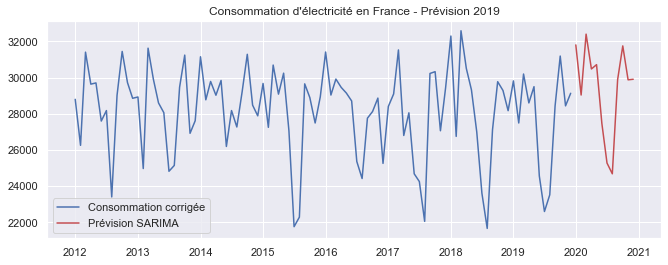

In [659]:
#Visualisation de la prévision à 12 mois par la méthode SARIMA
pred_model = results.get_forecast(12)
pred = pred_model.predicted_mean

plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), pred, color='r', label='Prévision SARIMA')

plt.title("Consommation d'électricité en France - Prévision 2019")
plt.legend()

plt.savefig('p9_graphs/sarima_prevision2019.jpg')
plt.show() 

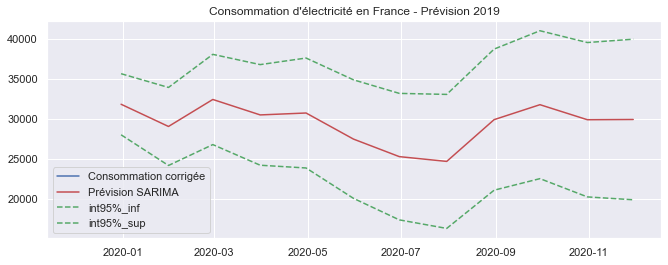

In [660]:
#Visualisation des intervalles de confiance sur la prévision à 12 mois
pred_model = results.get_forecast(12)
pred = pred_model.predicted_mean

pred_l = [(elt[0]) for elt in pred_model.conf_int(alpha=0.05)]
pred_u = [(elt[1]) for elt in pred_model.conf_int(alpha=0.05)]

plt.plot(df['conso_corr'].iloc[-1:], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), pred, color='r', label='Prévision SARIMA')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), 
         pred_l, color='g', linestyle='--', label='int95%_inf')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), 
         pred_u, color='g', linestyle='--', label='int95%_sup')

plt.title("Consommation d'électricité en France - Prévision 2019")
plt.legend()

plt.savefig('p9_graphs/sarima_prevision2019_int95.jpg')
plt.show() 

n intervalle de confiance globalement satisfaisant. Notons qu'il semble y avoir un niveau d'incertitude plus marqué sur une durée de prévision plus longue.

### Analyse a posteriori

On tronque la série de l’année 2018, qu’on cherche ensuite à prévoir à partir de l’historique 2012-2017.

In [ ]:
#Troncature des données sur les années 2017 et 2018
df_tronc = df[:'2017'] 
x_prevision = df['2018':]  

In [ ]:
model_tronc = SARIMAX(np.asarray(df_tronc['conso_corr']), order=(1,1,1), seasonal_order=(2,1,1,12))
results_tronc = model_tronc.fit()
print(results_tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results_tronc.resid, lags=elt)[1].mean()))

Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%.

In [ ]:
#Visualisation par restriction sur l'année 2018
pred_model_tronc = results_tronc.get_forecast(12)
pred_tronc = pred_model_tronc.predicted_mean

plt.plot(df["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(x_prevision.index, pred_tronc, color='r', label='Prévision SARIMA')


plt.title("Consommation d'électricité en France 2018 - Prévision a posteriori 2018")
        
plt.legend()
plt.savefig("p9_graphic/prevision_visu20182018_sarima_aposteriori.png")
plt.show()

In [ ]:
mape = round((np.abs(1-pred_tronc/x_prevision["conso_corr"])).mean()*100, 2)
mape

Prévision à 12 mois performante, sans s'arrêter strictement au MAPE, la méthode SARIMA semble mieux prendre en compte les impacts saisonniers (pics et creux).

In [ ]:
#Troncature des données pour une prévision a posteriori de 24 mois
df_tronc = df[:'2016']
x_prevision = df['2017':]

In [ ]:
model_tronc = SARIMAX(np.asarray(df_tronc['conso_corr']), order=(1,1,1), seasonal_order=(2,1,1,12))
results_tronc = model_tronc.fit()
print(results_tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results_tronc.resid, lags=elt)[1].mean()))

Notons qu'il n'est pas facile de tester une prévision a posteriori sur 24 mois sans avoir à réoptimiser le modèle. Ici, un paramètre AR saisonnier n'est plus significatif, il serait donc nécessaire de le retrirer pour pouvoir ré-évaluer la prédiction. Ici, il n'est pas utile d'aller plus loin dans cette démarche de ré-optimisation du modèle, celui choisi satisfait nos objectifs de prédiction à 12 mois.

### Conclusion

Dans cette étude, nous avons utilisé les données mensuelles de consommation d’électricité en France, ainsi que l'effet de température lié au chauffage pour tester des modèles de prévison de cette consommation à 12 mois. L’exploration de ces données nous a révélé des caracteristiques tels que la non stationnarité de la série de consommation d’électricité et sa très forte inertie (autocorrélation forte et longue). Deux processus de différenciation ont été nécessaire pour rendre la série stationnaire.

Les prévisions par la méthode de lissage exponentiel Holt-Winters et SARIMA sont globablement satisfaisantes, avec l’erreur absolue moyenne en pourcentage au dessous de 3%. Par ailleurs, le modèle SARIMA sera retenu prioritairement pour prédire la consommation d’électricité plus ponctuelle (à court terme), il sera plus performant et plus robuste dans des prévisions devant prendre en compte de forts impacts saisonniers.